<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-del-projecto-equipo_62/blob/main/Reto2/Reto2_Equipo62.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reto 2 - Clasificación-ensambles y presentación ejecutiva
## Ciencia y analítica de datos 

## Equipo 62
#### Integrantes:
- Ricardo Morales Bustillos - **A01740032**
- Alejandro Jesús Vázquez Navarro - **A01793146**

#### Profesora: Dra. María de la Paz Rico Fernández

#### 15 de noviembre de 2022


- Selecciona tus variables independientes X y dependiente Y (semáforo)
- Cambia a label encoding el semáforo, ej, de ["clase 1", "clase 2", "clase 3"] a [ 1,2,3]
- Realiza un análisis general de las features importances a traves de decision trees o random forest.
- Selecciona las variables de mayor importancia.
- Realiza tu clasificador, recuerda dividir los datos de manera balanceada (auxiliate de train test split)
- Explora que clasificador es el más optimo, ejemplo:
- Decision trees
- Random Forest.
- Determina el grado de exactitud a través del reporte de clasificación y análisis de la gráfica de Precision Recall.
- Visualiza los resultados del modelo o las predicciones a través de una matriz de confusión.
- Realiza un reporte de los principales hallazgos y conclusiones del experimento e incluyelos en una presentación ejecutiva de 10 diapositivas. La presentación deberá incluir todos los pasos del pipeline seguidos, limpieza, análisis, kmeans, clasificación, resultados y conclusiones.

### Preparación

In [ ]:
# Carga de librerías necesarias

import pandas as pd
import numpy as np


# Para visualización

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

# Para la imputación de datos:
from sklearn.impute import SimpleImputer

# Para escalar los datos:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import ParameterGrid

# Para el split
from sklearn.model_selection import train_test_split 

# Para el reporte de clasificacion
from sklearn.metrics import classification_report


# Para cálculo de intercuartiles
from scipy.stats import iqr

# Para PCA
from sklearn.decomposition import PCA

# Para Kmeans
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.classifier import PrecisionRecallCurve


# Para DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


# Para RandomForestClassifier 
from sklearn.ensemble import RandomForestClassifier


# Para las curvas de aprendizaje
from sklearn.model_selection import learning_curve, validation_curve

# Para los pipelines
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# Para la validación cruzada
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold

# Para el fine tuning
from sklearn.model_selection import GridSearchCV

# Para las métricas
from sklearn import metrics 

#Para probar las métricas
from sklearn.metrics import classification_report, make_scorer
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score

# Para la ROC y la Precision - Recall Curve
from sklearn.metrics import RocCurveDisplay   
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

# Para las gráficas de mapa
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import geoplot.crs as gcrs
import geoplot as gplt
import mapclassify as mc
from sklearn.tree import export_graphviz

from graphviz import Source

from shapely.geometry import Point

# Para tabulación
from tabulate import tabulate

In [ ]:
# Variables
path = r"C:\Users\aleja\Jupyter Notebooks\maestria\CdD\Retos\Entrega1\Datos_de_calidad_del_agua_2020"
filedb = r"Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_superficiales_2020.csv"

filePath = path + "\\" + filedb

DEBUG = False

In [ ]:
# Funciones

def limpieza_caracteres(df, campos):
    
    for i in campos:
        df[i] = df[i].str.replace('<', '')
        
    return df

def correlation_heatmap(dataframe,l,w):
    #correlations = dataframe.corr()
    correlation = dataframe.corr()
    plt.figure(figsize=(l,w))
    sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='viridis')
    plt.title('Correlation between different fearures')
    plt.show();
    

def KMeans_cluster(data, k):
    my_kmeans = KMeans(n_clusters= k)
    my_kmeans.fit(data) 
    clusters = my_kmeans.predict(data) 
    centroids = my_kmeans.cluster_centers_
    return clusters,  pd.DataFrame(centroids)


#####################################################
#           FUNCIONES AD HOC METRICAS               #
#####################################################


# Celda de métricas

def nues_accuracy(yreal,ypred):
  cm = confusion_matrix(yreal,ypred).ravel()
  vn, fp, fn, vp = cm[0], cm[1], cm[2], cm[3]
  accuracy = (vp + vn) / (vn + fp + fn + vp)
  return accuracy

def nues_precision(yreal,ypred):
  cm = confusion_matrix(yreal,ypred).ravel()
  vn, fp, fn, vp = cm[0], cm[1], cm[2], cm[3]
  precision = vp / (vp + fp)
  return precision

def nues_recall(yreal,ypred):
  cm = confusion_matrix(yreal,ypred).ravel()
  vn, fp, fn, vp = cm[0], cm[1], cm[2], cm[3]
  recall = vp / (vp + fn)
  return recall

def nues_f1score(yreal,ypred):
  cm = confusion_matrix(yreal,ypred).ravel()
  vn, fp, fn, vp = cm[0], cm[1], cm[2], cm[3]
  f1score = (2*vp) / (2*vp + fp + fn)
  return f1score

def nues_gmean(yreal,ypred):
  cm = confusion_matrix(yreal,ypred).ravel()
  vn, fp, fn, vp = cm[0], cm[1], cm[2], cm[3]
  recall,specifity = vp / (vp + fn), vn / (vn + fp)
  gmean =  np.sqrt(recall*specifity)
  return gmean

##################################################
#              FÁBRICA DE MODELOS                #
# ################################################
 
def get_models():

    modelos = list()
    nombres = list()

  # DT - Árbol de Decisión:
    modelos.append(DecisionTreeClassifier())
    nombres.append('DT')
  
  # RF - Random Forest:
    modelos.append(RandomForestClassifier())
    nombres.append('RF')  

    return modelos, nombres

################################################
#            CURVAS DE APRENDIZAJE             #
################################################


# Funciones de ayuda para la learning curve
def mi_LearningCurvePlot(metrica, train_sizes, train_scores, val_scores):

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(7,6))
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.1, color='blue')
    
    plt.plot(train_sizes, val_mean, color='red', marker='+', markersize=5, linestyle='--', label='Validation')
    plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.1, color='red')
    
    plt.title('Curvas de Aprendizaje incrementando el tamaño de la muestra')
    plt.xlabel('Tamaño del conjunto de entrenamiento')
    plt.ylabel(metrica)
    plt.grid()
    plt.legend(loc='lower left')
    plt.show()
    

### Adquisición de datos

In [ ]:
# Adquisición de datos

dfMain = pd.read_csv(filePath)
dfMain.head()


y = dfMain["SEMAFORO"]
lat = dfMain["LATITUD"]
long = dfMain["LONGITUD"]

coordenadas = dfMain[["LATITUD", "LONGITUD"]]

### Limpieza de datos 

Debido a que los datos ya los hemos limpiado y preparado en el **Reto 1** en este reto no realizaremos el análisis completo de la limpieza, solo aplicaremos las rutinas de limpieza y tratamiento de datos en una sola celda.

In [ ]:
# Solo para entender la distribución de algunas variables que tenían el caracter ">", realizamos
# este análisis de histograma

dfMain = dfMain.replace('<', '', regex=True)

# Debido a que las variables TOX_D_48_FON_UT, CALIDAD_TOX_D_48_FON, TOX_FIS_FON_15_UT, CALIDAD_TOX_FIS_FON_15 
# no tienen datos, las eliminaremos
# También eliminaré PERIODO pues todo es del 2020
# Se elimina CLAVE, no tiene sentido porque es un identificador
# Se elimina SITIO porque se convertirían en 12 columnas en OneHot
# Se elimina ESTADO porque ya tenemos las coordenadas y nos quitamos de 32 columnas OneHot
# Se elimina MUNICIPIO pues son 752 municipios que tendríamos que convertir en 752 columnas
# lo cual convertiría nuestro dataset en algo inmanehable en una laptop
# Se elimina CUENCA pues se convertiría en e506 columnas
# Se elimina CUERPO DE AGUA pues sería 1056 columnas extras
# Se elimina TIPO pues existe una columna GRUPO muy similar
# Contaminantes también se elimina pues está redundante la información en otras columnas

colsEliminiar = ["CLAVE", "PERIODO", "SITIO", "ESTADO", "MUNICIPIO", "CUENCA", "CUERPO DE AGUA", 
"TIPO", "TOX_D_48_FON_UT","CALIDAD_TOX_D_48_FON", "TOX_FIS_FON_15_UT", "CONTAMINANTES", "CALIDAD_TOX_FIS_FON_15"]



dfMain.drop(columns = colsEliminiar, inplace=True)


camposLimpiarCaracter = ["DBO_mg/L", "DQO_mg/L", "SST_mg/L", "COLI_FEC_NMP_100mL", "E_COLI_NMP_100mL",
                         "ENTEROC_NMP_100mL", "OD_PORC", "OD_PORC_SUP", "OD_PORC_MED", "OD_PORC_FON", 
                         "TOX_D_48_UT", "TOX_V_15_UT", "TOX_D_48_SUP_UT", "TOX_FIS_SUP_15_UT"]


# Realizamos una copia del dfMain
dfLimpieza01 = dfMain.copy()

# Almacenamos los campos en una variable X
X = dfLimpieza01[camposLimpiarCaracter] 

imputer = SimpleImputer(missing_values=np.nan, strategy='median', verbose=1)

# Rellenamos los NaN con mediana
transformed_values = imputer.fit_transform(X)

column = X.columns

dfLimpiezaA = pd.DataFrame(transformed_values, columns = column )

# Por las magnitudes de las variables es necesario escalaras:
# Realizamos una copia del dfMain
dfLimpieza02 = dfLimpiezaA.copy()

# Almacenamos los campos en una variable X
X = dfLimpieza02[camposLimpiarCaracter] 

scaler = MinMaxScaler()

# Escalamos
scaled = scaler.fit_transform(X)

column = X.columns

dfLimpiezaB = pd.DataFrame(scaled, columns = column )
    
dfMain = dfMain.drop(columns=camposLimpiarCaracter)

dfLimpiezaC = pd.concat([dfMain, dfLimpiezaB], axis=1)

dfMain2 = dfLimpiezaC.copy()
camposNulos = dfMain2.isnull().sum()


categoricas = ["SUBTIPO", "CALIDAD_DBO", "CALIDAD_DQO", "CALIDAD_SST",
              "CALIDAD_COLI_FEC", "CALIDAD_E_COLI", "CALIDAD_ENTEROC", "CALIDAD_OD_PORC",  "CALIDAD_OD_PORC_SUP",
               "CALIDAD_OD_PORC_MED", "CALIDAD_OD_PORC_FON", "CALIDAD_TOX_D_48", "CALIDAD_TOX_V_15", 
               "CALIDAD_TOX_D_48_SUP", "CALIDAD_TOX_FIS_SUP_15"]

X = dfMain2[categoricas] 

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
transformed_values = imputer.fit_transform(X)

column = X.columns

dfLimpiezaD = pd.DataFrame(transformed_values, columns = column )

dfMain3 = dfMain2.drop(columns=categoricas)

dfLimpiezaE= pd.concat([dfMain3,dfLimpiezaD], axis=1)

dfMain4 =  dfLimpiezaE.copy()

#Elegir con cuáles columnas nos quedaremos y qué tratamiento le daremos

colCategoricas = ["SUBTIPO", "CALIDAD_DBO", "CALIDAD_DQO", "ORGANISMO_DE_CUENCA", "SUBTIPO", "CALIDAD_SST", "CALIDAD_COLI_FEC", "CALIDAD_E_COLI",
                 "CALIDAD_ENTEROC", "CALIDAD_OD_PORC", "CALIDAD_OD_PORC_SUP", "CALIDAD_OD_PORC_MED", "CALIDAD_OD_PORC_FON",
                 "CALIDAD_TOX_D_48", "CALIDAD_TOX_V_15", "CALIDAD_TOX_D_48_SUP", "CALIDAD_TOX_FIS_SUP_15",
                  "CUMPLE_CON_DBO","CUMPLE_CON_DQO","CUMPLE_CON_SST","CUMPLE_CON_CF",
                  "CUMPLE_CON_E_COLI","CUMPLE_CON_ENTEROC","CUMPLE_CON_OD","CUMPLE_CON_TOX","GRUPO"
                 ]

colNumericas = ["COLI_FEC_NMP_100mL","DBO_mg/L","DQO_mg/L","ENTEROC_NMP_100mL","E_COLI_NMP_100mL",
                "OD_PORC","OD_PORC_FON","OD_PORC_MED","OD_PORC_SUP","SST_mg/L",
                "TOX_D_48_SUP_UT",
                "TOX_D_48_UT","TOX_FIS_SUP_15_UT","TOX_V_15_UT"]

colLatitudLongitud= ["LONGITUD", "LATITUD"]

print(f"La forma del dataset dfMain4 es {dfMain4.shape}")
print(f"Una inspección rápida de la calidad del dataframe {dfMain4.isnull().sum()}")


La forma del dataset dfMain4 es (3493, 42)
Una inspección rápida de la calidad del dataframe ORGANISMO_DE_CUENCA       0
LONGITUD                  0
LATITUD                   0
SEMAFORO                  0
CUMPLE_CON_DBO            0
CUMPLE_CON_DQO            0
CUMPLE_CON_SST            0
CUMPLE_CON_CF             0
CUMPLE_CON_E_COLI         0
CUMPLE_CON_ENTEROC        0
CUMPLE_CON_OD             0
CUMPLE_CON_TOX            0
GRUPO                     0
DBO_mg/L                  0
DQO_mg/L                  0
SST_mg/L                  0
COLI_FEC_NMP_100mL        0
E_COLI_NMP_100mL          0
ENTEROC_NMP_100mL         0
OD_PORC                   0
OD_PORC_SUP               0
OD_PORC_MED               0
OD_PORC_FON               0
TOX_D_48_UT               0
TOX_V_15_UT               0
TOX_D_48_SUP_UT           0
TOX_FIS_SUP_15_UT         0
SUBTIPO                   0
CALIDAD_DBO               0
CALIDAD_DQO               0
CALIDAD_SST               0
CALIDAD_COLI_FEC          0
CALIDAD_E_C

In [ ]:
dfMain4.columns

Index(['ORGANISMO_DE_CUENCA', 'LONGITUD', 'LATITUD', 'SEMAFORO',
       'CUMPLE_CON_DBO', 'CUMPLE_CON_DQO', 'CUMPLE_CON_SST', 'CUMPLE_CON_CF',
       'CUMPLE_CON_E_COLI', 'CUMPLE_CON_ENTEROC', 'CUMPLE_CON_OD',
       'CUMPLE_CON_TOX', 'GRUPO', 'DBO_mg/L', 'DQO_mg/L', 'SST_mg/L',
       'COLI_FEC_NMP_100mL', 'E_COLI_NMP_100mL', 'ENTEROC_NMP_100mL',
       'OD_PORC', 'OD_PORC_SUP', 'OD_PORC_MED', 'OD_PORC_FON', 'TOX_D_48_UT',
       'TOX_V_15_UT', 'TOX_D_48_SUP_UT', 'TOX_FIS_SUP_15_UT', 'SUBTIPO',
       'CALIDAD_DBO', 'CALIDAD_DQO', 'CALIDAD_SST', 'CALIDAD_COLI_FEC',
       'CALIDAD_E_COLI', 'CALIDAD_ENTEROC', 'CALIDAD_OD_PORC',
       'CALIDAD_OD_PORC_SUP', 'CALIDAD_OD_PORC_MED', 'CALIDAD_OD_PORC_FON',
       'CALIDAD_TOX_D_48', 'CALIDAD_TOX_V_15', 'CALIDAD_TOX_D_48_SUP',
       'CALIDAD_TOX_FIS_SUP_15'],
      dtype='object')

Hasta este momento hemos eliminado los nulos y escalado los datos.

#### Selecciona tus variables independientes X y dependiente Y (semáforo)

In [ ]:
# También quitaremos PERIODO, LATITUD y LONGITUD pues no ofrecen poder predictivo.

X = dfMain4[dfMain4.columns.difference(["SEMAFORO", "LATITUD", "LONGITUD", "CLAVE"])]
y = dfMain4[["SEMAFORO"]]

print(f'Verificar forma del vector de X {X.shape}')
print(f'Verificar y {y}')
print(f'Verificar dfMain {dfMain4.shape}')

Verificar forma del vector de X (3493, 39)
Verificar y       SEMAFORO
0         Rojo
1         Rojo
2         Rojo
3     Amarillo
4         Rojo
...        ...
3488  Amarillo
3489  Amarillo
3490      Rojo
3491  Amarillo
3492  Amarillo

[3493 rows x 1 columns]
Verificar dfMain (3493, 42)


Tenemos 39 características para X más y = 40 columnas para el dataframe llamado dfMain4

#### Cambia a label encoding el semáforo, ej, de ["clase 1", "clase 2", "clase 3"] a [ 1,2,3]


In [ ]:

lbEncoder = LabelEncoder()


df_encoded = y.apply(lbEncoder.fit_transform)
df_encoded.head() 


,SEMAFORO
0,1
1,1
2,1
3,0
4,1


#### Realiza un análisis general de las features importances a traves de decision trees o random forest.


In [ ]:
# Las variables categóricas necesitamos pasarlas a OneHotEncoding, eliminarlas del dfMain4 y después 
# incorporarlas al dfMain4 de variables numéricas para que toda la matriz nos quede con datos
# de tipo numérico

categoricas =  ['CALIDAD_TOX_D_48_SUP', 'CALIDAD_COLI_FEC', 'CALIDAD_DBO', 
'CALIDAD_DQO','CALIDAD_ENTEROC', 'CALIDAD_E_COLI', 'CALIDAD_OD_PORC', 
'CALIDAD_OD_PORC_FON','CALIDAD_OD_PORC_MED', 'CALIDAD_OD_PORC_SUP', 
'CALIDAD_SST', 'CALIDAD_TOX_D_48', 'CALIDAD_TOX_FIS_SUP_15', 
'CALIDAD_TOX_V_15', 'CUMPLE_CON_CF', 
'CUMPLE_CON_DBO', 'CUMPLE_CON_DQO', 'CUMPLE_CON_ENTEROC',
'CUMPLE_CON_E_COLI', 'CUMPLE_CON_OD', 'CUMPLE_CON_SST',
'CUMPLE_CON_TOX', 'GRUPO', 'ORGANISMO_DE_CUENCA', 'SUBTIPO']


numericas = set(X.columns).difference(set(categoricas))  

print(f'Longitud de la lista de columnas categóricas {len(categoricas)}')
print(f'Longitud de la lista de columnas numéricas {len(numericas)}')
print(f'Longitud total {len(categoricas) + len(numericas)}')



Longitud de la lista de columnas categóricas 25
Longitud de la lista de columnas numéricas 14
Longitud total 39


Transformemos las columnas categóricas en OneHotEncoder en un pipeline con RandomForestClassifer. Las numéricas ya están escaladas

In [ ]:

one_hot_encoded_data = pd.get_dummies(X, columns = categoricas)
X_features = one_hot_encoded_data
y_dependent = df_encoded["SEMAFORO"]

#X_features.to_csv("borrar.csv")



#### Características más importantes en el modelo:

Las 10 características más importantes
############################################################
              Feature  Importance  rank
2            DQO_mg/L    9.548584   1.0
0  COLI_FEC_NMP_100mL    5.653605   2.0
4    E_COLI_NMP_100mL    2.652755   3.0
1            DBO_mg/L    2.385129   4.0
3   ENTEROC_NMP_100mL    1.739198   5.0
5             OD_PORC    0.783067   6.0
9            SST_mg/L    0.649167   7.0
6         OD_PORC_FON    0.639490   8.0
8         OD_PORC_SUP    0.587918   9.0
7         OD_PORC_MED    0.264213  10.0


<Figure size 864x864 with 0 Axes>

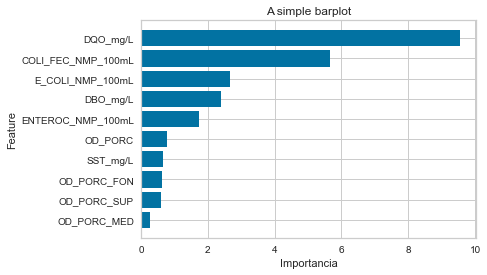

In [ ]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_features, y_dependent) 


features = X_features.columns.tolist() 
featureImpList= []

importance = rf.feature_importances_

###############################################
# Ordenamiento de las principales características
for feat, importance in zip(X_features.columns, importance):  
    temp = [feat, importance*100]
    featureImpList.append(temp)

fT_df = pd.DataFrame(featureImpList, columns = ['Feature', 'Importance'])

fT_df = fT_df.head(10)
fT_df["rank"] = fT_df["Importance"].rank(ascending=False)

print("Las 10 características más importantes")
print("###" * 20 )
print (fT_df.sort_values('Importance', ascending = False))

fT_df = fT_df.sort_values(by=['Importance'])

###############################################
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(12)

fig, ax = plt.subplots()    


ind = np.arange(len(fT_df.Importance))  # the x locations for the groups
width = 1.75 # the width of the bars 

# Create horizontal bars
plt.barh(y=fT_df.Feature, width=fT_df.Importance)


#ax.set_yticks(ind+width/2)
ax.set_yticklabels(fT_df.Feature, minor=False)

plt.xlabel('Importancia')
plt.ylabel('Feature') 

# Add title
plt.title('A simple barplot');


#### Realiza tu clasificador, recuerda dividir los datos de manera balanceada (auxiliate de train test split)


**Tomo solo las 10 características con mayor importancia en el dataset X**


In [ ]:
# Tomo solo las 10 características con mayor importancia en el dataset X


colsReducidas = fT_df["Feature"].values.tolist()
X_features = X_features[colsReducidas]

X_train, X_test, y_train, y_test = train_test_split(X_features, y_dependent, test_size=0.20, random_state=12)

print(f'Forna X Train {X_train.shape}')
print(f'Forna X Test {X_test.shape}')
print(f'Forna y Train {y_train.shape}')
print(f'Forna y Test {y_test.shape}')

Forna X Train (2794, 10)
Forna X Test (699, 10)
Forna y Train (2794,)
Forna y Test (699,)


#### Gráfica de Precision - Recall **Decision Tree**

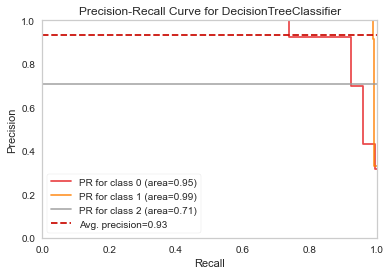

<AxesSubplot:title={'center':'Precision-Recall Curve for DecisionTreeClassifier'}, xlabel='Recall', ylabel='Precision'>

In [ ]:
modeloDT = DecisionTreeClassifier(class_weight = 'balanced', criterion = 'entropy', random_state=120, max_depth=3, min_samples_leaf=5)

modeloDT.fit(X_train, y_train)

y_pred_entropy = modeloDT.predict(X_test)


pred_bin = modeloDT.predict_proba(X_test)
pred_bin = pred_bin[:,1] 

results_DT = confusion_matrix(y_test, y_pred_entropy)
precision, recall, thresholds = precision_recall_curve(y_test, pred_bin, pos_label=1)

# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(
    DecisionTreeClassifier(class_weight = 'balanced', criterion = 'entropy', random_state=120, max_depth=3, min_samples_leaf=5),
    per_class=True,
    cmap="Set1"
)

viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()


#### Reporte de clasificación - **Decision Tree  Classifier**

In [ ]:
target_names = ['Verde', 'Amarillo', 'Rojo']

print(classification_report(y_test, y_pred_entropy, target_names=target_names))


              precision    recall  f1-score   support

       Verde       0.99      0.53      0.69       220
    Amarillo       1.00      0.99      0.99       231
        Rojo       0.70      1.00      0.83       248

    accuracy                           0.85       699
   macro avg       0.90      0.84      0.84       699
weighted avg       0.89      0.85      0.84       699



#### Gráfica de Precision - Recall **Random Forest Classifier**

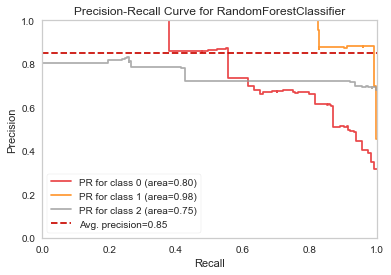

<AxesSubplot:title={'center':'Precision-Recall Curve for RandomForestClassifier'}, xlabel='Recall', ylabel='Precision'>

In [ ]:
modeloRF = RandomForestClassifier(ccp_alpha = 0.0001, class_weight = None, criterion = 'gini', max_depth = 1, min_samples_split = 0.1)

modeloRF.fit(X_train, y_train)

y_pred_ = modeloRF.predict(X_test)


pred_bin = modeloRF.predict_proba(X_test)
pred_bin = pred_bin[:,1] 

results_RF = confusion_matrix(y_test, y_pred_)
precision, recall, thresholds = precision_recall_curve(y_test, pred_bin, pos_label=1)


# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(
    modeloRF,
    per_class=True,
    cmap="Set1"
)

viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

#### Reporte de clasificación - **Random Forest Classifier**

In [ ]:
target_names = ['Verde', 'Amarillo', 'Rojo']

print(classification_report(y_test, y_pred_, target_names=target_names))


              precision    recall  f1-score   support

       Verde       0.99      0.57      0.73       220
    Amarillo       0.99      0.82      0.90       231
        Rojo       0.65      1.00      0.79       248

    accuracy                           0.81       699
   macro avg       0.88      0.80      0.81       699
weighted avg       0.87      0.81      0.81       699



### Decision Tree Classifier
#### Visualiza los resultados del modelo o las predicciones a través de una matriz de confusión.


[Text(0, 0.5, 'Verde'), Text(0, 1.5, 'Amarillo'), Text(0, 2.5, 'Rojo')]

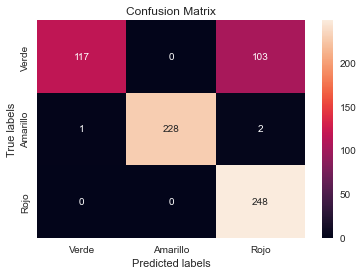

In [ ]:
ax= plt.subplot()
sns.heatmap(results_DT, annot=True, fmt='g', ax=ax)  

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 

ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)


### Random Forest Classifer
#### Visualiza los resultados del modelo o las predicciones a través de una matriz de confusión.


[Text(0, 0.5, 'Verde'), Text(0, 1.5, 'Amarillo'), Text(0, 2.5, 'Rojo')]

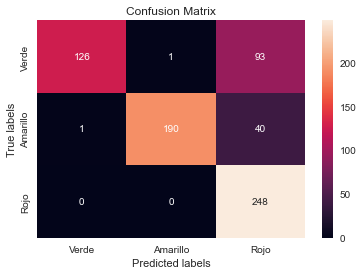

In [ ]:
ax= plt.subplot()
sns.heatmap(results_RF, annot=True, fmt='g', ax=ax)  

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 

ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)